In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
# Konfiguration

def make_config(person, trial):
    config = {
        'vicon_file_path': f'E:/Datenerhebung MA/Vicon_csv/mittelwert/{person}/60fps/{trial}_mittelwert_60fps.csv',
        'poseformer_file_path': {
            'cam1': f'E:/Datenerhebung MA/PoseFormerV2 Daten/{person}/Cam1/{trial}_1/pose3D_keypoints/combined/combined_keypoints.npz',
            'cam2': f'E:/Datenerhebung MA/PoseFormerV2 Daten/{person}/Cam2_hoch/{trial}_2_hoch/pose3D_keypoints/combined/combined_keypoints.npz',           
            'cam3': f'E:/Datenerhebung MA/PoseFormerV2 Daten/{person}/Cam3/{trial}_3/pose3D_keypoints/combined/combined_keypoints.npz'
            
        },
        'mediapipe_0_file_path': {
            'cam1': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam1/Complexity0/{trial}_1_comp0.csv',
            'cam2': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam2/Complexity0/{trial}_2_comp0.csv',
            'cam3': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam3/Complexity0/{trial}_3_comp0.csv'
        },
        'mediapipe_1_file_path': {
            'cam1': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam1/Complexity1/{trial}_1_comp1.csv',
            'cam2': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam2/Complexity1/{trial}_2_comp1.csv',
            'cam3': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam3/Complexity1/{trial}_3_comp1.csv'
        },
        'mediapipe_2_file_path': {
            'cam1': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam1/Complexity2/{trial}_1_comp2.csv',
            'cam2': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam2/Complexity2/{trial}_2_comp2.csv',
            'cam3': f'E:/Datenerhebung MA/MediaPipe/{person}/Cam3/Complexity2/{trial}_3_comp2.csv'
        },
        # Gelenkpunkte für verschiedene Systeme
        'joints': {
            'knee': {
                'right': {
                    'vicon': ['RHIP', 'RKNE', 'RANK', 'LHIP', 'RHIP'],  # Vicon-Punkte für rechtes Knie + linke/rechte hüfte
                    'poseformer': [1, 2, 3, 4, 1],            # Poseformer-Indizes für rechtes Knie + linke/rechte hüfte
                    'mediapipe': [24, 26, 28, 23, 24]           # Mediapipe-Indizes für rechtes Knie + linke/rechte hüfte
                },
                'left': {
                    'vicon': ['LHIP', 'LKNE', 'LANK', 'LHIP', 'RHIP'],  # Vicon-Punkte für linkes Knie + linke/rechte hüfte
                    'poseformer': [4, 5, 6, 4, 1],            # Poseformer-Indizes für linkes Knie + linke/rechte hüfte
                    'mediapipe': [23, 25, 27, 23, 24]           # Mediapipe-Indizes für linkes Knie + linke/rechte hüfte
                }
            },
            'shoulder': {
                'right': {
                    'vicon': ['RHIP', 'RSHO', 'RELB'], # Vicon-Punkte für rechte Schulter
                    'poseformer': [1, 14, 15],           # Poseformer-Indizes für rechte Schulter
                    'mediapipe': [24, 12, 14]            # Mediapipe-Indizes für rechte Schulter
                },
                'left': {
                    'vicon': ['LHIP', 'LSHO', 'LELB'], # Vicon-Punkte für linke Schulter
                    'poseformer': [4, 11, 12],          # Poseformer-Indizes für linke Schulter
                    'mediapipe': [23, 11, 13]            # Mediapipe-Indizes für linke Schulter
                }
            },
            'elbow': {
                'right': {
                    'vicon': ['RSHO', 'RELB', 'RWRIST'], # Vicon-Punkte für rechte Schulter
                    'poseformer': [14, 15, 16],           # Poseformer-Indizes für rechte Schulter
                    'mediapipe': [12, 14, 16]            # Mediapipe-Indizes für rechte Schulter
                },
                'left': {
                    'vicon': ['LSHO', 'LELB', 'LWRIST'], # Vicon-Punkte für linke Schulter
                    'poseformer': [11, 12, 13],          # Poseformer-Indizes für linke Schulter
                    'mediapipe': [11, 13, 15]            # Mediapipe-Indizes für linke Schulter
                } 
        },
    }}
    return config


### Winkelberechnungs-Funktion

In [3]:
def calculate_angle_original(p1, p2, p3):
    """ 
    Originalversion für Berechnung des Kniewinkels
    """
    v1 = p1 - p2
    v2 = p3 - p2
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
    return angle

def calculate_angle_plane(p1, p2, p3, p4, p5):
    """
    p1: hip
    p2: knee
    p3: ankle
    p4: left hip (=p1 für linkes Knie)
    p5: right hip (=p1 für rechtes Knie)
    
    Wir berechnen den Kniewinkel als Winkel zwischen 
    - der Ebene, die durch die Hüfte und den Oberschenkel gegeben ist
    - dem Vektor des Unterschenkels

    Das ist anders als der Winkel zwischen Ober- und Unterschenkel
    Bei z.B. X-Beinen hat ein ausgestrecktes Bein einen Winkel < 180 Grad. Dieser Winkel ist aber in der Ebene und für uns nicht relevant.
    """
    
    v1 = p1 - p2  # oberschenkel
    v2 = p2 - p3  # unterschenkel

    hip_left_right_vector = p5 - p4  # hüfte von links nach rechts

    plane_norm = np.cross(v1, hip_left_right_vector)  # normalvektor der Ebene

    # winkel zwischen ebene und normalvektor berechnen
    cos_angle = np.dot(plane_norm, v2) / (np.linalg.norm(plane_norm) * np.linalg.norm(v2))
    angle = 90 + np.degrees(np.arccos(cos_angle))

    #print("plane", angle)
    
    return angle

def calculate_angle(p1, p2, p3, p4, p5):
    angle = calculate_angle_original(p1, p2, p3)
    #angle = calculate_angle_plane(p1, p2, p3, p4, p5)
    return angle
        

In [4]:
def _calculate_angle(p1, p2, p3, p4, p5):
    angle_original = calculate_angle_original(p1, p2, p3)
    angle_plane = calculate_angle_plane(p1, p2, p3, p4, p5)
    if angle_original <150:
        angle = angle_original
    else:
        angle = angle_plane

    return angle

### Definition zur Extraktion der Gelenkwinkel für Vicon, PoseFormerV2 und Mediapipe

In [5]:
def extract_vicon_joint_angles(vicon_file_path, joint_points):
    data = pd.read_csv(vicon_file_path)

    #data = data[550:600]
    
    # Extrahiere die Koordinaten für das gegebene Gelenk (z.B. Knie oder Schulter)
    joint_coords = {}
    for point in joint_points:
        joint_coords[point] = data[[f'{point}:X', f'{point}:Y', f'{point}:Z']].values
    
    # Berechne die Winkel
    angles = [calculate_angle(joint_coords[joint_points[0]][i],
                              joint_coords[joint_points[1]][i],
                              joint_coords[joint_points[2]][i],
                              joint_coords[joint_points[3]][i],
                              joint_coords[joint_points[4]][i],)
              for i in range(len(joint_coords[joint_points[0]]))]
    
    return angles


def extract_poseformer_joint_angles(poseformer_file_path, joint_indices):
    data = np.load(poseformer_file_path)
    
    # Extrahiere die Koordinaten für das gegebene Gelenk (z.B. Knie oder Schulter)
    angles = []
    for key in data.keys():
        frame = data[key]
        p1, p2, p3, p4, p5 = frame[joint_indices[0]], frame[joint_indices[1]], frame[joint_indices[2]], frame[joint_indices[3]], frame[joint_indices[4]]
        angles.append(calculate_angle(p1, p2, p3, p4, p5))
    
    return angles



def extract_mediapipe_joint_angles(mediapipe_file_path, joint_indices):
    data = pd.read_csv(mediapipe_file_path)
    
    # Extrahiere die relevanten Koordinaten für das gegebene Gelenk
    joint_coords = {}
    for i, joint in enumerate(joint_indices):
        joint_coords[i] = data[data['landmark_index'] == joint][['x', 'y', 'z']].values
    
    # Berechne den Winkel für jeden Frame
    angles = []
    for i in range(len(joint_coords[0])):
        p1, p2, p3, p4, p5 = joint_coords[0][i], joint_coords[1][i], joint_coords[2][i], joint_coords[3][i], joint_coords[4][i]
        angles.append(calculate_angle(p1, p2, p3, p4, p5))
    
    return angles

In [6]:
def calculate_angle_differences(vicon_angles, model_angles):
     # Sicherstellen, dass alle Arrays die gleiche Länge haben
    min_length = min(len(vicon_angles), len(model_angles))
        # Arrays auf gleiche Länge trimmen
    vicon_angles = np.array(vicon_angles[:min_length])
    model_angles = np.array(model_angles[:min_length])
    # Berechnung der Differenzen
    diff = model_angles - vicon_angles    

    return diff

### Definition für Plots von Poseformer und Mediapipe jeweils mit Vicon als Ground Truth

In [7]:


def get_angles(config, model, left_right):
    # model sollte "poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2" sein
    path = f"{model}_file_path"

    # Kniegelenkwinkel für rechtes (falls left_right == 'right') oder linkes (falls left_right == 'left') Knie berechnen
    vicon_angles = extract_vicon_joint_angles(config['vicon_file_path'], config['joints']['knee'][left_right]['vicon'])

    if model == 'poseformer':
        model_angles_cam1 = extract_poseformer_joint_angles(config[path]['cam1'], config['joints']['knee'][left_right]['poseformer'])
        model_angles_cam2 = extract_poseformer_joint_angles(config[path]['cam2'], config['joints']['knee'][left_right]['poseformer'])
        model_angles_cam3 = extract_poseformer_joint_angles(config[path]['cam3'], config['joints']['knee'][left_right]['poseformer'])
    else: 
        model_angles_cam1 = extract_mediapipe_joint_angles(config[path]['cam1'], config['joints']['knee'][left_right]['mediapipe'])
        model_angles_cam2 = extract_mediapipe_joint_angles(config[path]['cam2'], config['joints']['knee'][left_right]['mediapipe'])
        model_angles_cam3 = extract_mediapipe_joint_angles(config[path]['cam3'], config['joints']['knee'][left_right]['mediapipe'])

    return vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3


def get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3):
    diff_cam1 = calculate_angle_differences(vicon_angles, model_angles_cam1)
    diff_cam2 = calculate_angle_differences(vicon_angles, model_angles_cam2)
    diff_cam3 = calculate_angle_differences(vicon_angles, model_angles_cam3)

    return diff_cam1, diff_cam2, diff_cam3


In [8]:


def plot_angles(config, trial, person, left_right):
    # left_right ist "left" oder "right"
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
    fig.suptitle(f"Gelenkwinkel Vergleich ({trial}, {person}, {left_right})")
    
    models = ["poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2"]
    
    for model, axis in zip(models, [ax1, ax2, ax3, ax4]):
        try:
            vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, left_right)
        except Exception as error:
            print(f"An exception occurred in {trial} {person} {left_right} {model}", error) # An exception occurred: 
            continue

            
        start_frame = 500
        end_frame = 1000

        # Plot für Vicon
        axis.plot(vicon_angles, label='Vicon', color='blue', linewidth=1)
        axis.plot(model_angles_cam1, label=f'Cam 1', color='green', linestyle='--')
        axis.plot(model_angles_cam2, label=f'Cam 2', color='orange', linestyle='--')
        axis.plot(model_angles_cam3, label=f'Cam 3', color='red', linestyle='--')
        axis.set_xlim((start_frame, end_frame))
        axis.set_ylim((0, 250))
        # Titel, Labels und Legende
        axis.set_title(model)
        axis.set_xlabel('Frame')
        axis.set_ylabel('Winkel (Grad)')
        axis.legend()
        axis.grid(True)

        #break

    plt.tight_layout()
    plt.savefig(f"E:/Datenerhebung MA/Plots & Auswertung/knee/angles/sprint500-1000/{person}_{trial}_{left_right}.png")
    plt.show()
    plt.close()
    



In [9]:


def plot_differences(config, trial, person, left_right):
    # left_right ist "left" oder "right"
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
    fig.suptitle(f"Gelenkwinkel Unterschied ({trial}, {person}, {left_right})")
    
    models = ["poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2"]
    
    for model, axis in zip(models, [ax1, ax2, ax3, ax4]):
        try:
            vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, left_right)
        except Exception as error:
            print(f"An exception occurred in plot_differences {trial} {person} {left_right} {model}", error)
            continue

        diff_cam1, diff_cam2, diff_cam3 = get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3)

        start_frame = 500
        end_frame = 2000

     
        axis.plot(diff_cam1, label=f'Cam 1', color='green', linestyle='--')
        axis.plot(diff_cam2, label=f'Cam 2', color='orange', linestyle='--')
        axis.plot(diff_cam3, label=f'Cam 3', color='red', linestyle='--')
        axis.set_xlim((start_frame, end_frame))
        axis.set_ylim((-100, 100))
        # Titel, Labels und Legende
        axis.set_title(model)
        axis.set_xlabel('Frame')
        axis.set_ylabel('Winkelunterschied (Grad)')
        axis.legend()
        axis.grid(True)

    plt.tight_layout()
    plt.savefig(f"E:/Datenerhebung MA/Plots & Auswertung/knee/angle_differences/{person}_{trial}_{left_right}.png")
    #plt.show()
    plt.close()
    



In [10]:


def plot_differences_scatter(config, trial, person, left_right):
    # left_right ist "left" oder "right"
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
    fig.suptitle(f"Gelenkwinkel Unterschied ({trial}, {person}, {left_right})")
    
    models = ["poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2"]
    
    for model, axis in zip(models, [ax1, ax2, ax3, ax4]):
        try:
            vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, left_right)
        except Exception as error:
            print(f"An exception occurred in plot_differences_scatter {trial} {person} {left_right} {model}", error)
            continue

        diff_cam1, diff_cam2, diff_cam3 = get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3)

        start_frame = 500
        end_frame = 2000

     
       
        axis.scatter(vicon_angles[start_frame:end_frame], diff_cam1[start_frame:end_frame], alpha=0.2, label="Cam1 Differenz", s=3, color='green')
        axis.scatter(vicon_angles[start_frame:end_frame], diff_cam2[start_frame:end_frame], alpha=0.2, label="Cam2 Differenz", s=3, color='orange')
        axis.scatter(vicon_angles[start_frame:end_frame], diff_cam3[start_frame:end_frame], alpha=0.2, label="Cam3 Differenz", s=3, color='red')
        #axis.set_xlim((start_frame, end_frame))
        axis.set_ylim((-100, 100))
        # Titel, Labels und Legende
        axis.set_title(f"{model} frame: {start_frame} - {end_frame}")
        axis.set_xlabel('Vicon Gelenkwinkel')
        axis.set_ylabel('Model-Vicon Differenz (Grad)')
        axis.legend()
        axis.grid(True)

    plt.tight_layout()
   # plt.savefig(f"E:/Datenerhebung MA/Plots & Auswertung/knee/angle_differences_scatter/{person}_{trial}_{left_right}.png")
    plt.show()
    plt.close()
    



In [31]:


def plot_differences_scatter_newaxis(config, trial, person, left_right):
    # left_right ist "left" oder "right"
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
    fig.suptitle(f"Gelenkwinkel Unterschied ({trial}, {person}, {left_right})")
    
    models = ["poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2"]
    
    for model, axis in zip(models, [ax1, ax2, ax3, ax4]):
        try:
            vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, left_right)
        except Exception as error:
            print(f"An exception occurred in plot_differences_scatter {trial} {person} {left_right} {model}", error)
            continue

        diff_cam1, diff_cam2, diff_cam3 = get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3)

        start_frame = 500
        end_frame = 2000

     
       
        axis.scatter(model_angles_cam1[start_frame:end_frame], diff_cam1[start_frame:end_frame], alpha=0.2, label="Cam1 Differenz", s=3, color='green')
        axis.scatter(model_angles_cam2[start_frame:end_frame], diff_cam2[start_frame:end_frame], alpha=0.2, label="Cam2 Differenz", s=3, color='orange')
        axis.scatter(model_angles_cam3[start_frame:end_frame], diff_cam3[start_frame:end_frame], alpha=0.2, label="Cam3 Differenz", s=3, color='red')
        #axis.set_xlim((start_frame, end_frame))
        axis.set_ylim((-100, 100))
        # Titel, Labels und Legende
        axis.set_title(f"{model} frame: {start_frame} - {end_frame}")
        axis.set_xlabel(f'{model} Gelenkwinkel')
        axis.set_ylabel('Vicon Winkel (Grad)')
        axis.legend()
        axis.grid(True)

    plt.tight_layout()
    plt.savefig(f"E:/Datenerhebung MA/Plots & Auswertung/knee/angle_differences_scatter_newaxis/{person}_{trial}_{left_right}.png")
    #plt.show()
    plt.close()
    


In [33]:
def plot_correlation(config, trial, person, left_right):
    # left_right ist "left" oder "right"
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 9))
    fig.suptitle(f"Gelenkwinkel Unterschied ({trial}, {person}, {left_right})")
    
    models = ["poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2"]
    
    for model, axis in zip(models, [ax1, ax2, ax3, ax4]):
        try:
            vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, left_right)
        except Exception as error:
            print(f"An exception occurred in plot_differences_scatter {trial} {person} {left_right} {model}", error)
            continue

        diff_cam1, diff_cam2, diff_cam3 = get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3)

        start_frame = 500
        end_frame = 2000

        # Scatterplots für die Daten
        axis.scatter(model_angles_cam1[start_frame:end_frame], vicon_angles[start_frame:end_frame], alpha=0.2, label="Cam1", s=3, color='green')
        axis.scatter(model_angles_cam2[start_frame:end_frame], vicon_angles[start_frame:end_frame], alpha=0.2, label="Cam2", s=3, color='orange')
        axis.scatter(model_angles_cam3[start_frame:end_frame], vicon_angles[start_frame:end_frame], alpha=0.2, label="Cam3", s=3, color='red')
        
        # Hinzufügen der Linie y=x
        axis.plot([40, 200], [40, 200], color='black', linestyle='--', linewidth=1, label="y=x Linie")
        
        # Achsentitel, Labels und Legende
        axis.set_ylim((40, 200))
        axis.set_xlim((40, 200))
        axis.set_title(f"{model} frame: {start_frame} - {end_frame}")
        axis.set_xlabel(f'{model} Gelenkwinkel')
        axis.set_ylabel('Vicon Winkel (Grad)')
        axis.legend()
        axis.grid(True)

    plt.tight_layout()
    plt.savefig(f"E:/Datenerhebung MA/Plots & Auswertung/knee/angle_correlation/{person}_{trial}_{left_right}.png")
    plt.show()
    plt.close()



In [35]:
persons = ["AEN262", "DMN261",  "MUN261", "NSN261", "JKN261",  "MAN262" ]  #"AEN262", "DMN261",  "MUN261", "NSN261", "JKN261",  "MAN262" 

trials_v1 = ['01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs', '13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'] #'01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs', '13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'
trials_v2 = ['01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint'] #'01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint'

person_to_trials = {
    "AEN262": trials_v2,
    "DMN261": trials_v2, 
    "MAN262": trials_v1,
    "MUN261": trials_v1,
    "NSN261": trials_v2,
    "JKN261": trials_v1,
}



for person in persons:
    for trial in person_to_trials[person]:
        
        
        # person = AEN262, trail = 01_squat 
        config = make_config(person, trial)
        print(f"Plotting for {person} and {trial}...")

        left_right = 'left'

        #plot_angles(config, trial, person, left_right)

        try:
            #plot_differences_scatter(config, trial, person, left_right)
            plot_differences_scatter_newaxis(config, trial, person, left_right)
            #plot_correlation(config, trial, person, left_right)
            pass
        except Exception as error:
            print(f"An exception occurred in {trial} {person} {left_right}", error)
        continue
        #break

    #break




Plotting for AEN262 and 01_squat...
Plotting for AEN262 and 02_squat...
Plotting for AEN262 and 05_torso...
Plotting for AEN262 and 06_torso...
Plotting for AEN262 and 09_ebs...
Plotting for AEN262 and 10_ebs...
Plotting for AEN262 and 13_step...
Plotting for AEN262 and 14_step...
Plotting for AEN262 and 17_tubes...
Plotting for AEN262 and 18_tubes...
Plotting for AEN262 and 21_sprint...
Plotting for AEN262 and 22_sprint...
Plotting for DMN261 and 01_squat...
Plotting for DMN261 and 02_squat...
Plotting for DMN261 and 05_torso...
Plotting for DMN261 and 06_torso...
Plotting for DMN261 and 09_ebs...
Plotting for DMN261 and 10_ebs...
Plotting for DMN261 and 13_step...
Plotting for DMN261 and 14_step...
Plotting for DMN261 and 17_tubes...
Plotting for DMN261 and 18_tubes...
Plotting for DMN261 and 21_sprint...
Plotting for DMN261 and 22_sprint...
Plotting for MUN261 and 01_step...
Plotting for MUN261 and 02_step...
Plotting for MUN261 and 05_squat...
Plotting for MUN261 and 06_squat...
Pl

C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


Plotting for NSN261 and 05_torso...


C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


Plotting for NSN261 and 06_torso...


C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


Plotting for NSN261 and 09_ebs...


C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


Plotting for NSN261 and 10_ebs...


C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


Plotting for NSN261 and 13_step...


C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


Plotting for NSN261 and 14_step...


C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


Plotting for NSN261 and 17_tubes...


C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


Plotting for NSN261 and 18_tubes...
Plotting for NSN261 and 21_sprint...
Plotting for NSN261 and 22_sprint...


C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_9768\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


Plotting for JKN261 and 01_step...
Plotting for JKN261 and 02_step...
Plotting for JKN261 and 05_squat...
Plotting for JKN261 and 06_squat...
Plotting for JKN261 and 09_ebs...
Plotting for JKN261 and 10_ebs...
Plotting for JKN261 and 13_tubes...
Plotting for JKN261 and 14_tubes...
Plotting for JKN261 and 17_sprint...
Plotting for JKN261 and 18_sprint...
Plotting for JKN261 and 21_torso...
Plotting for JKN261 and 22_torso...
Plotting for MAN262 and 01_step...
Plotting for MAN262 and 02_step...
Plotting for MAN262 and 05_squat...
Plotting for MAN262 and 06_squat...
Plotting for MAN262 and 09_ebs...
Plotting for MAN262 and 10_ebs...
Plotting for MAN262 and 13_tubes...
Plotting for MAN262 and 14_tubes...
Plotting for MAN262 and 17_sprint...
Plotting for MAN262 and 18_sprint...
Plotting for MAN262 and 21_torso...
Plotting for MAN262 and 22_torso...


# Boxplots

In [17]:
trial_groups_v1 = {
    'step':  ['01_step', '02_step'], 
    'squat': ['05_squat', '06_squat'], 
    'ebs':   ['09_ebs', '10_ebs'], 
    'tubes': ['13_tubes', '14_tubes'], 
    'sprint': ['17_sprint', '18_sprint'], 
    'torso': ['21_torso', '22_torso']
}
trial_groups_v2 = {
    'squat': ['01_squat', '02_squat'], 
    'torso': ['05_torso', '06_torso'], 
    'ebs': ['09_ebs', '10_ebs'], 
    'step': ['13_step', '14_step'], 
    'tubes': ['17_tubes', '18_tubes'], 
    'sprint': ['21_sprint', '22_sprint']
}

person_to_trial_groups = {
    "AEN262": trial_groups_v2,
    "DMN261": trial_groups_v2, 
    "MAN262": trial_groups_v1,
    "MUN261": trial_groups_v1,
    "NSN261": trial_groups_v2,
    "JKN261": trial_groups_v1,
}

def get_angle_differences_for_boxplot(trail_group, cam, left_right, persons):
    """
    Returns a dictionary with one entry per model:
    For each model, we combine all angle differences for all persons and for the two trials within given trial_group
    e.g. for trial_group 'squat', we collect all angle differences for trials ['01_squat', '02_squat'] / ['05_squat', '06_squat']
    """
    models = ["poseformer", "mediapipe_0", "mediapipe_1", "mediapipe_2"]

    differences_combined = {
        'poseformer': [],
        'mediapipe_0': [],
        'mediapipe_1': [],
        'mediapipe_2': []
    }
    differences_combined_per_person = {}
    
    for person in persons:
        # z.B: person = 'AEN262'
        trials = person_to_trial_groups[person][trail_group]  # z.B. trails = ['01_squat', '02_squat']
        print(f"  ... person {person}, trials {trials}")
        for trial in trials:
            config = make_config(person, trial)
            for model in models:
                try:
                    vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, left_right)
                except Exception as error:
                    print(f"An exception occurred in plot_differences_scatter {trial} {person} {left_right} {model}", error)
                    continue
            
                diff_cam1, diff_cam2, diff_cam3 = get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3)

                if cam == 'cam1':
                    diff = diff_cam1
                elif cam == 'cam2':
                    diff = diff_cam2
                elif cam == 'cam3':
                    diff = diff_cam3
                else: 
                    raise ValueError(f"Invalid cam: {cam}")

                start_frame = 800
                end_frame = 2000

                diff_geschnitten = diff[start_frame:end_frame]
                differences_combined[model].extend(diff_geschnitten)
                if f"{model}_{person}" in differences_combined_per_person:
                    differences_combined_per_person[f"{model}_{person}"].extend(diff_geschnitten)
                else: 
                    differences_combined_per_person[f"{model}_{person}"] = list(diff_geschnitten)
    
        #break
        
    return differences_combined, differences_combined_per_person


def plot_box_plots_diff(trail_group, left_right, persons):
    
    
    fig, (row1, row2, row3) = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), width_ratios=(1,2))
    fig.suptitle(f"Gelenkwinkel Unterschied ({trail_group}, {left_right})")

    for row, cam in zip([row1, row2, row3], ['cam1', 'cam2', 'cam3']):
        axis_left = row[0]
        axis_right = row[1]
        print(f"Collecting angle differences for camera {cam} and trial_group {trial_group} {left_right}, persons {persons}")
        differences_combined, differences_combined_per_person = get_angle_differences_for_boxplot(trial_group, cam, left_right, persons)
        
        #axis_left.hlines([0], xmin=0.5, xmax=4.5, color='k', alpha=0.5, linestyles='dashed')
        axis_left.boxplot(differences_combined.values(), labels=differences_combined.keys())
        axis_left.set_title(cam)
        axis_left.set_ylim((-100, 100))
        axis_left.set_ylabel("Winkeldifferenz (Grad)")
        axis_left.grid(True, axis='y')
        for label in axis_left.get_xticklabels():
          label.set_rotation(45)
          label.set_ha('right')

        
        positions = []  # positions for boxplots: Abstände zwischen personen (+i)
        for i in range(len(persons)):
              positions.extend([i*4+i, i*4+1+i, i*4+2+i, i*4+3+i])
        axis_right.boxplot(differences_combined_per_person.values(), labels=differences_combined_per_person.keys(),
                          positions=positions)
        axis_right.set_title(cam)
        axis_right.set_ylim((-100, 100))
        axis_right.set_ylabel("Winkeldifferenz (Grad)")
        axis_right.grid(True, axis='y')
        for label in axis_right.get_xticklabels():
          label.set_rotation(45)
          label.set_ha('right')

        #break


    plt.tight_layout()
    output_dir = "E:/Datenerhebung MA/Plots & Auswertung/knee/angle_differences_boxplot/"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}{trial_group}_{left_right}.png")
    #plt.show()
    plt.close()


In [46]:
left_right = 'left'

trial_group = 'squat'
plot_box_plots_diff(trial_group, left_right, persons=["AEN262", "DMN261"]) #"MUN261", "NSN261", "JKN261", "MAN262"

trial_group = 'step'
plot_box_plots_diff(trial_group, left_right, persons=["AEN262", "DMN261",  "MUN261", "NSN261", "MAN262", "JKN261"])

trial_group = 'sprint'
plot_box_plots_diff(trial_group, left_right, persons=["AEN262", "DMN261",  "MUN261", "NSN261", "JKN261", "MAN262"])


  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person AEN262, trials ['13_step', '14_step']
  ... person DMN261, trials ['13_step', '14_step']
  ... person MUN261, trials ['01_step', '02_step']
  ... person NSN261, trials ['13_step', '14_step']
  ... person MAN262, trials ['01_step', '02_step']
  ... person JKN261, trials ['01_step', '02_step']
  ... person AEN262, trials ['13_step', '14_step']
  ... person DMN261, trials ['13_step', '14_step']
  ... person MUN261, trials ['01_step', '02_step']
  ... person NSN261, trials ['13_step', '14_step']
  ... person MAN262, trials ['01_step', '02_step']
  ... person JKN261, trials ['01_step', '02_step']
  ... person AEN262, trials ['13_step', '14_step']
  ... person DMN261

## Scatterplot für alle Übungen einer Person (oder eine Übung aller Personen)

In [20]:
import os
import csv
import numpy as np

def calculate_and_save_angles(person, trial, model, left_right, output_dir):

    # Stelle sicher, dass das Zielverzeichnis existiert
    os.makedirs(output_dir, exist_ok=True)

    # Lade die Konfiguration
    config = make_config(person, trial)

    # Versuche, die Winkel für die Kameras zu berechnen
    try:
        vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3 = get_angles(config, model, left_right)

        # Berechne die Differenzen
        diff_cam1, diff_cam2, diff_cam3 = get_differences(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3)

        # Erstelle eine CSV-Datei
        output_file = os.path.join(output_dir, f"{person}_{trial}_{model}_{left_right}_angles.csv")
        with open(output_file, mode="w", newline="") as csvfile:
            csvwriter = csv.writer(csvfile)

            # Schreibe die Header-Zeile
            csvwriter.writerow([
                "Frame", 
                "Vicon_Angles", 
                "Poseformer_Angles_Cam1", "Poseformer_Angles_Cam2", "Poseformer_Angles_Cam3",
                "Cam1_Difference", "Cam2_Difference", "Cam3_Difference"
            ])

            # Füge die Winkel und Differenzen zeilenweise hinzu (nur für Frames 500 bis 2000)
            for frame, (vicon, cam1, cam2, cam3, diff1, diff2, diff3) in enumerate(
                zip(vicon_angles, model_angles_cam1, model_angles_cam2, model_angles_cam3, diff_cam1, diff_cam2, diff_cam3)
            ):
                if 500 <= frame <= 2000:
                    csvwriter.writerow([frame, vicon, cam1, cam2, cam3, diff1, diff2, diff3])

        print(f"Die Winkel wurden erfolgreich in {output_file} gespeichert.")

    except Exception as e:
        print(f"Ein Fehler ist aufgetreten: {e}")

In [28]:
persons = ["AEN262", "DMN261",  "MUN261", "NSN261", "JKN261",  "MAN262" ]  #"AEN262", "DMN261",  "MUN261", "NSN261", "JKN261",  "MAN262" 

trials_v1 = [ '05_squat', '06_squat'] #'01_step', '02_step', '05_squat', '06_squat', '09_ebs', '10_ebs', '13_tubes', '14_tubes', '17_sprint', '18_sprint', '21_torso', '22_torso'
trials_v2 = ['01_squat', '02_squat'] #'01_squat', '02_squat', '05_torso', '06_torso', '09_ebs', '10_ebs', '13_step', '14_step', '17_tubes', '18_tubes', '21_sprint', '22_sprint'

person_to_trials = {
    "AEN262": trials_v2,
    "DMN261": trials_v2, 
    "MAN262": trials_v1,
    "MUN261": trials_v1,
    "NSN261": trials_v2,
    "JKN261": trials_v1,
}

output_dir = f"E:/Datenerhebung MA/MediaPipe/{person}/angles_csv"
model = 'mediapipe_2'

for person in persons:
    for trial in person_to_trials[person]:
        
        
        # person = AEN262, trail = 01_squat 
        config = make_config(person, trial)
        print(f"Saving CSV for {person} and {trial}...")
        output_dir = f"E:/Datenerhebung MA/Mediapipe/{person}/angles_csv"

        left_right = 'left'

        try:
            calculate_and_save_angles(person, trial, model, left_right, output_dir)
            pass
        except Exception as error:
            print(f"An exception occurred in {trial} {person} {left_right}", error)
        continue
        #break

    #break




Saving CSV for AEN262 and 01_squat...
Die Winkel wurden erfolgreich in E:/Datenerhebung MA/Mediapipe/AEN262/angles_csv\AEN262_01_squat_mediapipe_2_left_angles.csv gespeichert.
Saving CSV for AEN262 and 02_squat...
Die Winkel wurden erfolgreich in E:/Datenerhebung MA/Mediapipe/AEN262/angles_csv\AEN262_02_squat_mediapipe_2_left_angles.csv gespeichert.
Saving CSV for AEN262 and 05_torso...
Die Winkel wurden erfolgreich in E:/Datenerhebung MA/Mediapipe/AEN262/angles_csv\AEN262_05_torso_mediapipe_2_left_angles.csv gespeichert.
Saving CSV for AEN262 and 06_torso...
Die Winkel wurden erfolgreich in E:/Datenerhebung MA/Mediapipe/AEN262/angles_csv\AEN262_06_torso_mediapipe_2_left_angles.csv gespeichert.
Saving CSV for AEN262 and 09_ebs...
Die Winkel wurden erfolgreich in E:/Datenerhebung MA/Mediapipe/AEN262/angles_csv\AEN262_09_ebs_mediapipe_2_left_angles.csv gespeichert.
Saving CSV for AEN262 and 10_ebs...
Die Winkel wurden erfolgreich in E:/Datenerhebung MA/Mediapipe/AEN262/angles_csv\AEN262_

In [32]:
import os
import pandas as pd

person = ('NSN261')
trial= ('step')
# Pfad zu dem Ordner, der die CSV-Dateien enthält
folder_path = f"E:/Datenerhebung MA/PoseFormerV2 Daten/winkel_csv_uebungen/{trial}"

# Liste aller Dateien im Ordner mit der Endung '.csv'
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')  and f != "combined_data.csv"]

# Initialisiere einen leeren DataFrame für die kombinierten Daten
combined_data = pd.DataFrame()

# Iteriere über alle Dateien und füge sie zum kombinierten DataFrame hinzu
for file in all_files:
    file_path = os.path.join(folder_path, file)
    try:
        # Lade die Datei
        df = pd.read_csv(file_path)
        
        # Optionale Spalte hinzufügen, um die Quelle zu markieren
        df['Source_File'] = file
        
        # Kombiniere die Daten
        combined_data = pd.concat([combined_data, df], ignore_index=True)
    except Exception as e:
        print(f"Fehler beim Verarbeiten der Datei {file}: {e}")

# Speichere die kombinierten Daten in einer neuen CSV-Datei
output_file = os.path.join(folder_path, f"E:/Datenerhebung MA/PoseFormerV2 Daten/winkel_csv_uebungen/{trial}/{trial}_all_winkel.csv")
combined_data.to_csv(output_file, index=False)

print(f"Alle Dateien wurden erfolgreich kombiniert und gespeichert in: {output_file}")

Alle Dateien wurden erfolgreich kombiniert und gespeichert in: E:/Datenerhebung MA/PoseFormerV2 Daten/winkel_csv_uebungen/step/step_all_winkel.csv


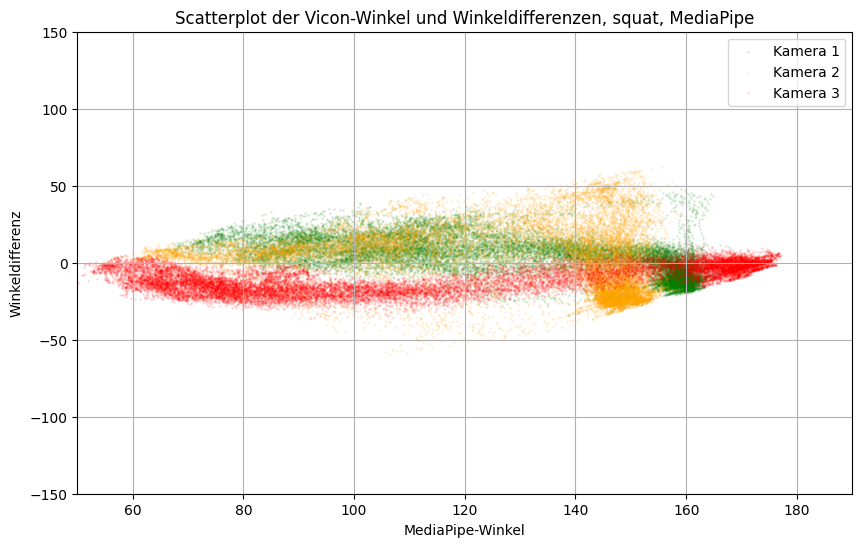

Der Scatterplot wurde als PNG unter 'E:/Datenerhebung MA/MediaPipe/Winkel_csv_uebungen/squat/scatterplot_MUN261_MediaPipe.png' gespeichert.


In [29]:

import pandas as pd
import matplotlib.pyplot as plt

person = 'MUN261'
model = 'MediaPipe'
trial= 'squat'
# CSV-Datei laden
file_path = f"E:/Datenerhebung MA/MediaPipe/Winkel_csv_uebungen/{trial}/{trial}_all_winkel.csv"
df = pd.read_csv(file_path)

# Scatterplot erstellen
plt.figure(figsize=(10, 6))

# Kamera 1
plt.scatter(df['Poseformer_Angles_Cam1'], df['Cam1_Difference'], label='Kamera 1', alpha=0.1, s=1, color='green')
# Kamera 2
plt.scatter(df['Poseformer_Angles_Cam2'], df['Cam2_Difference'], label='Kamera 2', alpha=0.1, s=1, color='orange')
# Kamera 3
plt.scatter(df['Poseformer_Angles_Cam3'], df['Cam3_Difference'], label='Kamera 3', alpha=0.1, s=1, color='red')


# Achsen anpassen (fixieren)
plt.xlim([50, 190])  # Puffer um die Daten
plt.ylim([-150, 150])  # Beispielbereich für die Winkeldifferenzen

# Plot anpassen
plt.xlabel(f'{model}-Winkel')
plt.ylabel('Winkeldifferenz')
plt.title(f'Scatterplot der Vicon-Winkel und Winkeldifferenzen, {trial}, {model}')
plt.legend()
plt.grid(True)

# Plot als PNG speichern
output_path = f"E:/Datenerhebung MA/MediaPipe/Winkel_csv_uebungen/{trial}/scatterplot_{person}_{model}.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Plot anzeigen
plt.show()

print(f"Der Scatterplot wurde als PNG unter '{output_path}' gespeichert.")


Boxplots für 2 Modelle

  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person JKN261, trials ['05_squat', '06_squat']
  ... person MAN262, trials ['05_squat', '06_squat']
  ... person MUN261, trials ['05_squat', '06_squat']
  ... person NSN261, trials ['01_squat', '02_squat']


C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person JKN261, trials ['05_squat', '06_squat']
  ... person MAN262, trials ['05_squat', '06_squat']
  ... person MUN261, trials ['05_squat', '06_squat']
  ... person NSN261, trials ['01_squat', '02_squat']


C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person JKN261, trials ['05_squat', '06_squat']
  ... person MAN262, trials ['05_squat', '06_squat']
  ... person MUN261, trials ['05_squat', '06_squat']
  ... person NSN261, trials ['01_squat', '02_squat']


C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person JKN261, trials ['05_squat', '06_squat']
  ... person MAN262, trials ['05_squat', '06_squat']
  ... person MUN261, trials ['05_squat', '06_squat']
  ... person NSN261, trials ['01_squat', '02_squat']


C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person JKN261, trials ['05_squat', '06_squat']
  ... person MAN262, trials ['05_squat', '06_squat']
  ... person MUN261, trials ['05_squat', '06_squat']
  ... person NSN261, trials ['01_squat', '02_squat']


C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


  ... person AEN262, trials ['01_squat', '02_squat']
  ... person DMN261, trials ['01_squat', '02_squat']
  ... person JKN261, trials ['05_squat', '06_squat']
  ... person MAN262, trials ['05_squat', '06_squat']
  ... person MUN261, trials ['05_squat', '06_squat']
  ... person NSN261, trials ['01_squat', '02_squat']


C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
C:\Users\localtest\AppData\Local\Temp\ipykernel_11580\2889907647.py:7: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


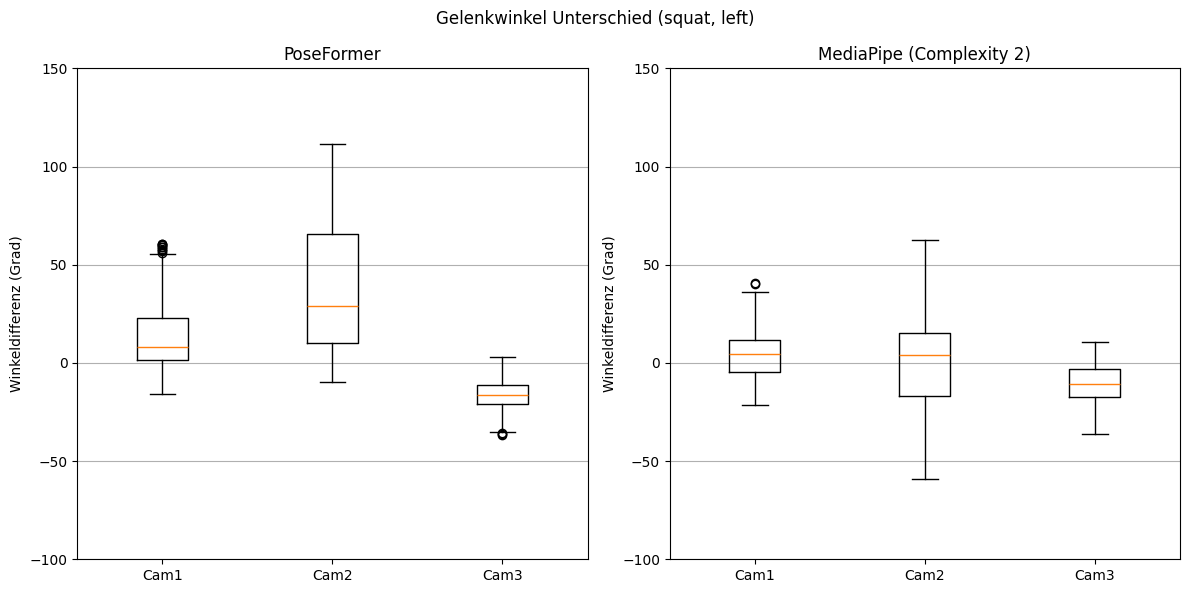

In [21]:
import matplotlib.pyplot as plt

def plot_box_plots_poseformer_vs_mediapipe(trial_group, left_right, persons):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle(f"Gelenkwinkel Unterschied ({trial_group}, {left_right})")

    models = ["poseformer", "mediapipe_2"]  # Die beiden Modelle
    axes = [ax1, ax2]
    titles = ["PoseFormer", "MediaPipe (Complexity 2)"]

    for model, axis, title in zip(models, axes, titles):
        print(f"Collecting angle differences for {model}, trial_group {trial_group}, {left_right}, persons {persons}")
        
        # Lade die Differenzdaten für alle drei Kameraperspektiven
        differences_cam1, _ = get_angle_differences_for_boxplot(trial_group, "cam1", left_right, persons)
        differences_cam2, _ = get_angle_differences_for_boxplot(trial_group, "cam2", left_right, persons)
        differences_cam3, _ = get_angle_differences_for_boxplot(trial_group, "cam3", left_right, persons)
        
        # Extrahiere nur die Werte für das gewünschte Modell
        data = [differences_cam1[model], differences_cam2[model], differences_cam3[model]]
        labels = ["Cam1", "Cam2", "Cam3"]
        
        # Boxplot erstellen
        axis.boxplot(data, labels=labels)
        axis.set_title(title)
        axis.set_ylim((-100, 150))
        axis.set_ylabel("Winkeldifferenz (Grad)")
        axis.grid(True, axis='y')

    plt.tight_layout()
    output_dir = "E:/Datenerhebung MA/Plots & Auswertung/knee/angle_differences_boxplot/"
    os.makedirs(output_dir, exist_ok=True)
   # plt.savefig(f"{output_dir}{trial_group}_{left_right}_poseformer_vs_mediapipe.png")
    plt.show()
    plt.close()

# Beispielaufruf
test_trial_group = "squat"
test_left_right = "left"
test_persons = ["AEN262", "DMN261", "JKN261", "MAN262", "MUN261", "NSN261"]
plot_box_plots_poseformer_vs_mediapipe(test_trial_group, test_left_right, test_persons)
